In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score


In [28]:
# Load the Titanic dataset (train.csv)
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
data = pd.read_csv(url)

# Show the first few rows of the dataset
data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Preprocessing

In [29]:
# Check for missing values
print(data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [30]:
# Fill missing values in the 'Age' column using median of each Pclass/Sex group
imputer = SimpleImputer(strategy='median')
data['Age'] = imputer.fit_transform(data[['Age']])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [31]:
# Drop the 'Cabin' column due to many missing values
#data = data.drop(columns='Cabin)
data = data.drop(columns=['Cabin'])

In [32]:
# Fill missing values in 'Embarked' column with the most common value
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

In [33]:
# Convert categorical columns to numerical using LabelEncoder
le = LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])  # 0 = female, 1 = male
data['Embarked'] = le.fit_transform(data['Embarked'])  # C = 0, Q = 1, S = 2

# Feature Engineering

In [34]:
# Create a new feature 'FamilySize'
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

In [35]:
# Create a new feature 'IsAlone' (1 = Alone, 0 = Not Alone)
data['IsAlone'] = 1  # Initialize to 1 (Alone)
data['IsAlone'].loc[data['FamilySize'] > 1] = 0  # Update for those with family

C:\Users\tonsi ten\AppData\Local\Temp\ipykernel_5784\2549554239.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['IsAlone'].loc[data['FamilySize'] > 1] = 0  # Update for those with family


In [36]:
# Create a new feature 'Title' extracted from the 'Name' column
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [37]:
# Group similar titles
data['Title'] = data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 
                                       'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')

In [38]:
# Convert 'Title' to numerical
data['Title'] = le.fit_transform(data['Title'])

In [39]:
# Drop unused columns
data = data.drop(columns=['PassengerId', 'Name', 'Ticket'])

data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title
0,0,3,1,22.0,1,0,7.2500,2,2,0,2
1,1,1,0,38.0,1,0,71.2833,0,2,0,3
2,1,3,0,26.0,0,0,7.9250,2,1,1,1
3,1,1,0,35.0,1,0,53.1000,2,2,0,3
4,0,3,1,35.0,0,0,8.0500,2,1,1,2


# Exploratory Data Analysis (EDA)

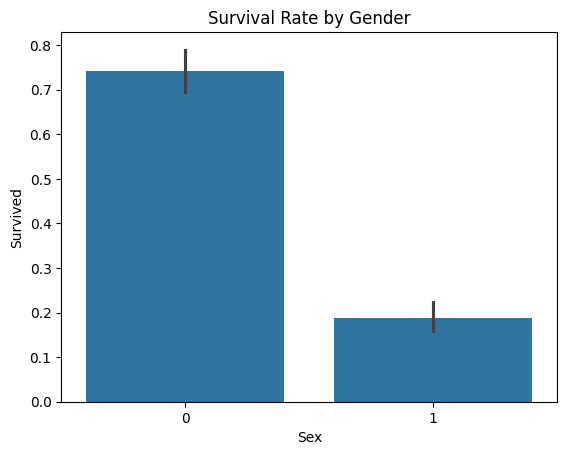

In [40]:
# Plot survival rate based on gender
sns.barplot(x='Sex', y='Survived', data=data)
plt.title('Survival Rate by Gender')
plt.show()

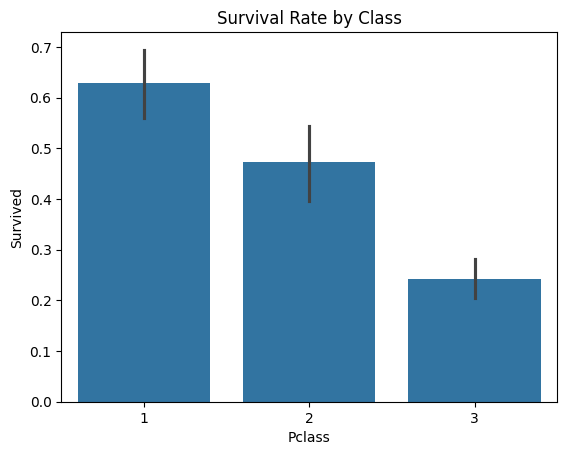

In [41]:
# Plot survival rate based on class
sns.barplot(x='Pclass', y='Survived', data=data)
plt.title('Survival Rate by Class')
plt.show()

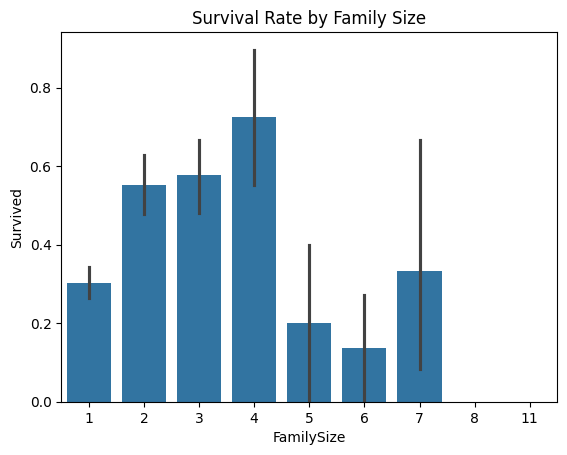

In [42]:
# Plot survival rate based on family size
sns.barplot(x='FamilySize', y='Survived', data=data)
plt.title('Survival Rate by Family Size')
plt.show()

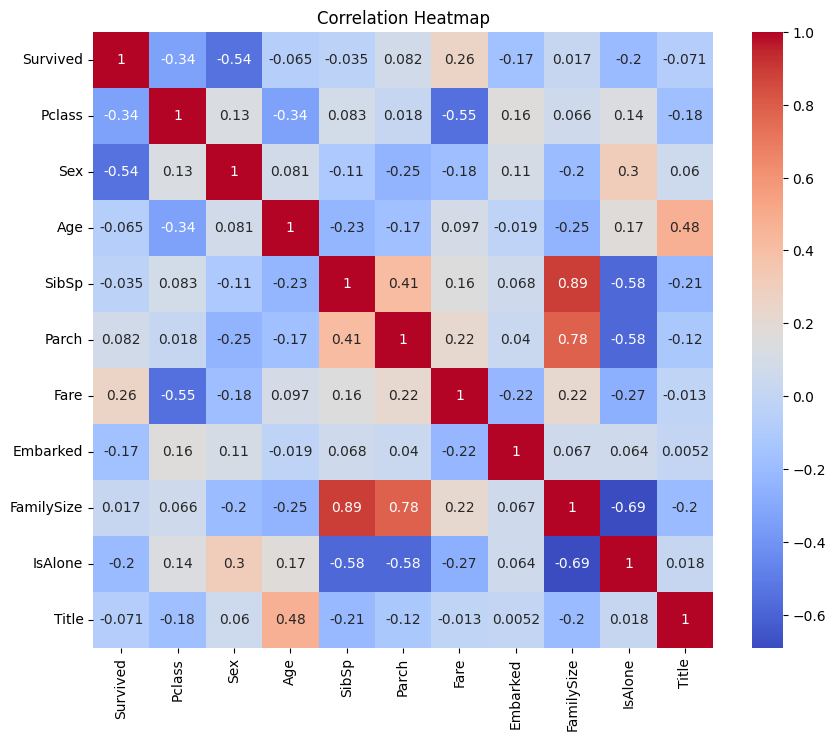

In [43]:
# Correlation heatmap to check relationships between features
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Split Data into Training and Testing Sets

In [44]:
# Split the data into features (X) and target (y)
X = data.drop(columns='Survived')
y = data['Survived']

In [45]:
# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((712, 10), (179, 10))

# Model Building

In [46]:
# Build a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [47]:
# Train the model
model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


RandomForestClassifier(random_state=42)

In [48]:
# Make predictions on the test set
y_pred = model.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [49]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 83.80%


In [50]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)


Confusion Matrix:
[[91 14]
 [15 59]]


In [51]:
# Classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       105
           1       0.81      0.80      0.80        74

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



In [52]:
# ROC-AUC score
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f'ROC-AUC Score: {roc_auc:.2f}')

ROC-AUC Score: 0.90


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


# Feature Importance

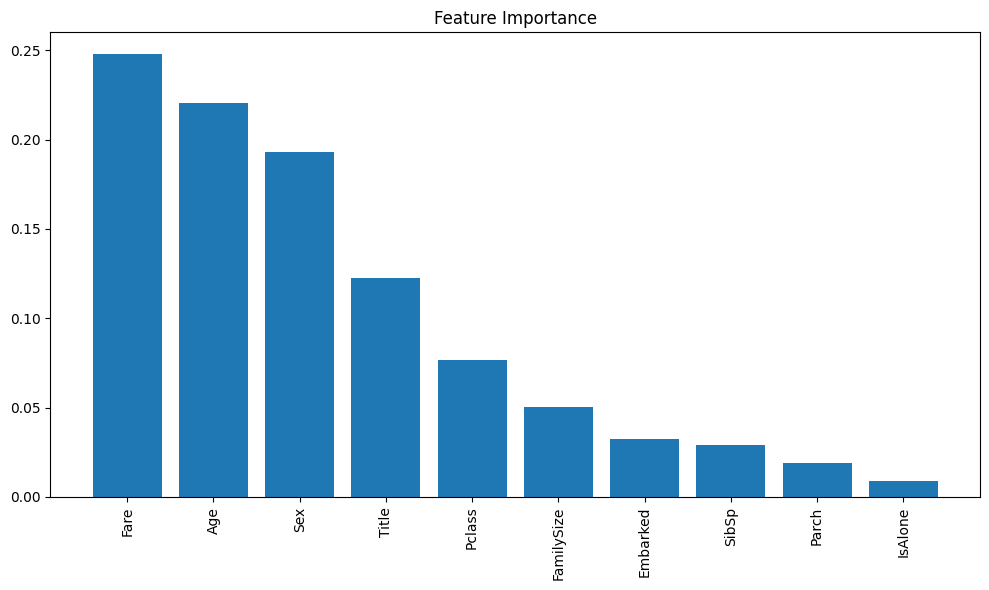

In [53]:
# Feature importance plot
importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()